# The Music of the Sphere: Fourier Series Representation of the Horizon-scale Potential

*Phil Marshall, Laurence Perreault Levasseur and Roger Blandford, August-October 2015*

In this notebook we look at some simulated potential fields, and predict the CMB temperature map from them.

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
%matplotlib inline
import healpy as hp
import numpy as np
import beatbox

## 1. Generating and Visualizing a 3D Potential

Our plan is to use a simple Fourier series, with terms lying within some sphere in k-space, to represent the potential on horizon scales. Let's instantiate such a "beatbox" universe and generate a Gaussian random potential field in it, using a simple inflation model to generate a power spectrum and then populate the covariance matrix.

In [20]:
We = beatbox.Universe()
We.generate_a_random_potential_field(high_k_cutoff=6, low_k_cutoff=2, n_s=0.96, kstar=0.02, PSnorm=2.43e-9, Pdist=1, Pmax=np.pi, Pvar=np.pi/8)

Generated  246  potential Fourier coefficients
 with phases uniformly distributed between 0 and  3.14159265359
Built potential grid, with dimensions  (41, 41, 41)  and mean value  -0.0 +/- 6.1e-06


beatbox/universe.py:188: RuntimeWarning: divide by zero encountered in power
  self.Power_Spectrum = self.PSnorm*np.power((self.k/self.kstar) ,(-3+(self.n_s-1)))


Now, let's visualize the 3D potential field, with `yt`. We're trying to make a plot like [this one](http://yt-project.org/doc/_images/vr_sample.jpg), as shown in the [volume rendering tutorial](http://yt-project.org/doc/visualizing/volume_rendering.html). [This `gist` (from Sam Skillman)](https://gist.github.com/samskillman/0e574d1a4f67d3a3b1b1) uses a development version of `yt` to do the rendering, but does show how to use `yt` data structures.

In [ ]:
# !pip install --upgrade Cython
# !pip install --upgrade yt

In [7]:
import yt 

# yt.visualization.color_maps.show_colormaps()

yt : [INFO     ] 2015-11-25 11:45:16,569 Parameters: current_time              = 0.0
yt : [INFO     ] 2015-11-25 11:45:16,570 Parameters: domain_dimensions         = [41 41 41]
yt : [INFO     ] 2015-11-25 11:45:16,570 Parameters: domain_left_edge          = [-1.95121951 -1.95121951 -1.95121951]
yt : [INFO     ] 2015-11-25 11:45:16,571 Parameters: domain_right_edge         = [ 1.95121951  1.95121951  1.95121951]
yt : [INFO     ] 2015-11-25 11:45:16,572 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2015-11-25 11:45:16,634 Loading field plugins.
yt : [INFO     ] 2015-11-25 11:45:16,634 Loaded angular_momentum (8 new fields)
yt : [INFO     ] 2015-11-25 11:45:16,635 Loaded astro (15 new fields)
yt : [INFO     ] 2015-11-25 11:45:16,636 Loaded cosmology (22 new fields)
yt : [INFO     ] 2015-11-25 11:45:16,703 Loaded fluid (64 new fields)
yt : [INFO     ] 2015-11-25 11:45:16,704 Loaded fluid_vector (96 new fields)
yt : [INFO     ] 2015-11-25 11:45:16,705 Loaded geometric (112 ne

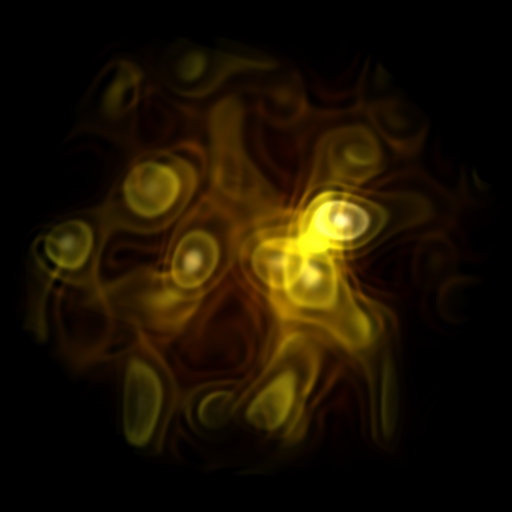

In [31]:
We.show_potential_with_yt(output='test1.png',angle=1.0,  N_layer=10, cmap='hot')

#from IPython.display import Image
#Image('test1.png',width=400)

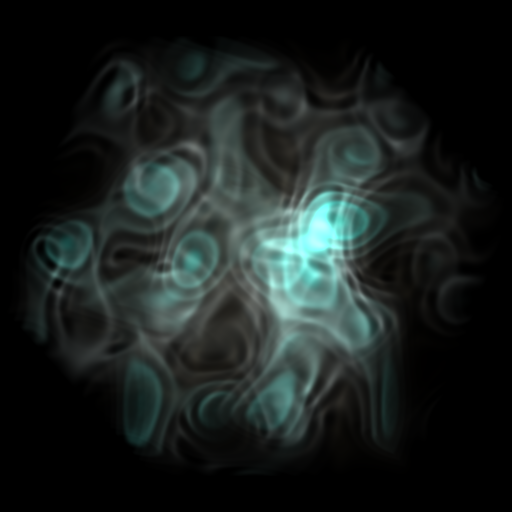

In [29]:
We.cam.show(clip_ratio=6)

In [ ]:
# %load -n We.show_potential_with_yt
# %load universe.py

We can also make a movie to show multiple angles - but the resulting animated gif is large (1.6Mb) so we'll skip this step.

In [ ]:
# !pip install --upgrade images2gif
# !pip install --upgrade PIL

In [ ]:
# We.show_potential_from_all_angles_with_yt(output='phi.gif')

In [ ]:
# Image(url='phi.gif',width=300)

## 2. Predicting the CMB Temperature Map

When we get to doing the inverse problem, we'll be sampling from the posterior PDF for the potential coefficients $f_n$, and will need to check that these models are indeed plausible. The first model check we will do will be visual, and will involve making mock CMB temperature maps for our model potentials (see [issue 8](https://github.com/rogerblandford/Music/issues/8)).

So, let's convert the Fourier coefficients `fn` into `alm`'s, using the appropriate response matrix:

In [ ]:
# We.transform_3D_potential_fourier_series_into_T_spherical_harmonics(lmax=3)
# We.show_CMB_T_map(from_perspective_of="observer")